Take a copy of this notebook for each model you will implement.

This is the initial notebook — any changes will be made here before starting model building to ensure consistency across all notebooks.

**Key Consistency Tips**

* Standardized Headings: Use identical section names across all notebooks.

* Code Comments: Explain non-trivial steps (e.g., "Handling class imbalance with SMOTE").

* Version Control: Add a requirements.txt in the repo for dependency management. مش لازم

* Outputs: Save all plots/figures to a /results folder with consistent naming (e.g., XGBoost_SHAP.png).
اعتقد هتبقى كويسة عشان واحنا بنعمل البيبر ما نقعدش ناخد سكرينات


* Reproducibility: Set global random seeds (e.g., np.random.seed(42)).

In [ ]:
# !git clone https://github.com/galalqassas/xai.git

# **Imports**

In [4]:
%%capture
!pip install -q lime shap

In [5]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import kagglehub
from sklearn.model_selection import train_test_split, learning_curve, ValidationCurveDisplay
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, RocCurveDisplay, auc
from sklearn.inspection import PartialDependenceDisplay
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.metrics import PrecisionRecallDisplay
import warnings
warnings.filterwarnings('ignore')

# **Utils**

In [6]:
def our_confusion_matrix(model, X_train, y_train, X_test, y_test, name='Model'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
    ConfusionMatrixDisplay.from_estimator(model, X_train, y_train, cmap="Oranges", ax=ax1)
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap="Oranges", ax=ax2)
    plt.title(f"{name} Confusion Matrix")

def our_roc(model, X_train, y_train, X_test, y_test, name="Model"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    roc1 = RocCurveDisplay.from_estimator(
    model, X_train, y_train,
    name=name, ax=ax1,
    color="orange" #juicy juicy
    )
    roc2 = RocCurveDisplay.from_estimator(
        model, X_test, y_test,
        name=name, ax=ax2,
        color="orange" #juicy juicy
    )
    ax1.fill_between(roc1.fpr, roc1.tpr, alpha=0.4, color="orange")
    ax2.fill_between(roc2.fpr, roc2.tpr, alpha=0.4, color="orange")
    ax1.set_title(f"{name} Training ROC Curve", fontsize=16)
    ax2.set_title(f"{name} Testing ROC Curve", fontsize=16)
    for ax in [ax1, ax2]:
        ax.grid(alpha=0.5)

def our_learning_curve(model, X_train, y_train, name='Model'):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=5, scoring='accuracy',
        train_sizes=np.linspace(0.1, 1.0, 10), random_state=0
    )

    plt.figure(figsize=(13, 8))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color="mediumseagreen", label="Training score")
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color="royalblue", label="Cross-validation score")
    plt.title(f"{name} Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid(alpha=0.5)

def our_prc(model, X_train, y_train, X_test, y_test, name="Model"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 13))
    train_disp = PrecisionRecallDisplay.from_estimator(model, X_train, y_train, ax=ax1, color='orange')
    test_disp = PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=ax2, color='orange')
    ax1.set_title(f"{name} Precision-Recall Curve - Train")
    ax2.set_title(f"{name} Precision-Recall Curve - Test")
    ax1.fill_between(train_disp.recall, train_disp.precision, alpha=0.4, color='orange')
    ax2.fill_between(test_disp.recall, test_disp.precision, alpha=0.4, color='orange')

# **Load Processed Dat**a

In [7]:
path = kagglehub.dataset_download('mohamedhassan77/xai-project-processed-data')
df = pd.read_csv(f"{path}/combined_adasyn_train_test.csv")
df

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,promotion_velocity,workload_score,compensation_ratio,Attrition,Set
0,31,2,1062,1,24,3,3,3,0,96,...,3,10.0,9,1,8,9.999900,1,1.019760,0,Train
1,50,2,328,1,1,3,3,3,1,86,...,2,3.0,2,0,2,300000.000000,2,1.281918,0,Train
2,46,2,717,1,13,4,1,3,1,34,...,3,10.0,7,0,9,1000000.000000,1,0.832635,0,Train
3,44,2,170,1,1,4,1,2,1,78,...,3,2.0,0,2,2,0.999995,1,0.753443,0,Train
4,26,1,1479,1,1,3,1,3,0,84,...,1,6.0,5,1,4,5.999940,3,1.007878,0,Train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2042,56,2,1162,1,24,2,1,1,1,97,...,3,4.0,2,1,0,3.999960,1,0.898732,1,Test
2043,46,2,669,2,9,2,3,3,1,64,...,3,9.0,8,4,7,2.249994,1,1.558490,1,Test
2044,30,2,1240,0,9,3,0,3,1,48,...,1,11.0,9,4,7,2.749993,7,2.052053,0,Test
2045,31,2,741,1,2,4,1,2,1,69,...,4,5.0,2,0,3,500000.000000,0,1.207921,0,Test


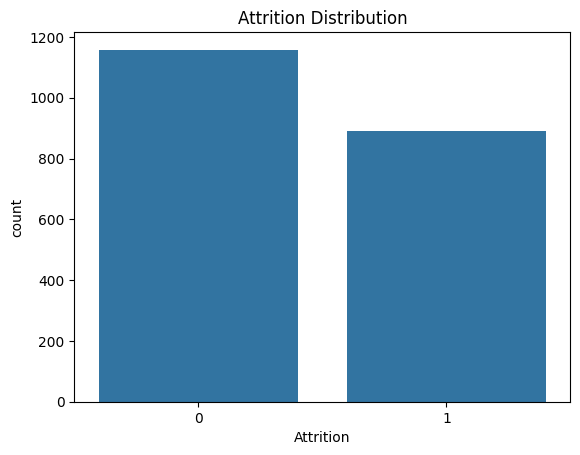

In [8]:
sns.countplot(x='Attrition', data=df)
plt.title('Attrition Distribution')
plt.show()

In [9]:
train_df = df[df['Set'] == 'Train'].drop(columns=['Set'])
test_df = df[df['Set'] == 'Test'].drop(columns=['Set'])

X_train = train_df.drop(columns=['Attrition'])
y_train = train_df['Attrition']

X_test = test_df.drop(columns=['Attrition'])
y_test = test_df['Attrition']

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

X_train: (1589, 33) y_train: (1589,)
X_test: (458, 33) y_test: (458,)


# **Model-Specific EDA (Optional)**

Text(0.5, 1.0, 'Example Feature Distribution After Scaling')

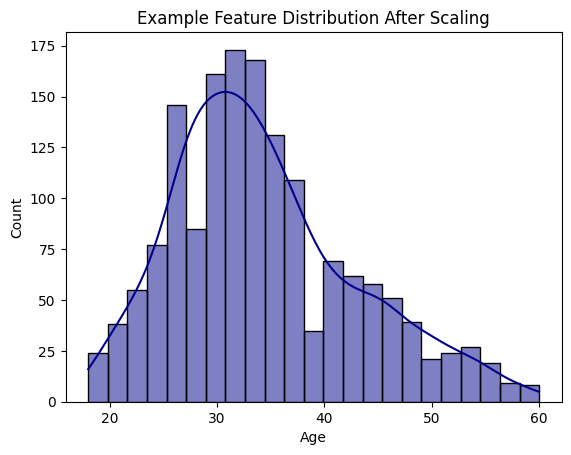

In [10]:
sns.histplot(X_train.iloc[:, 0], kde=True, color='darkblue')
plt.title("Example Feature Distribution After Scaling")

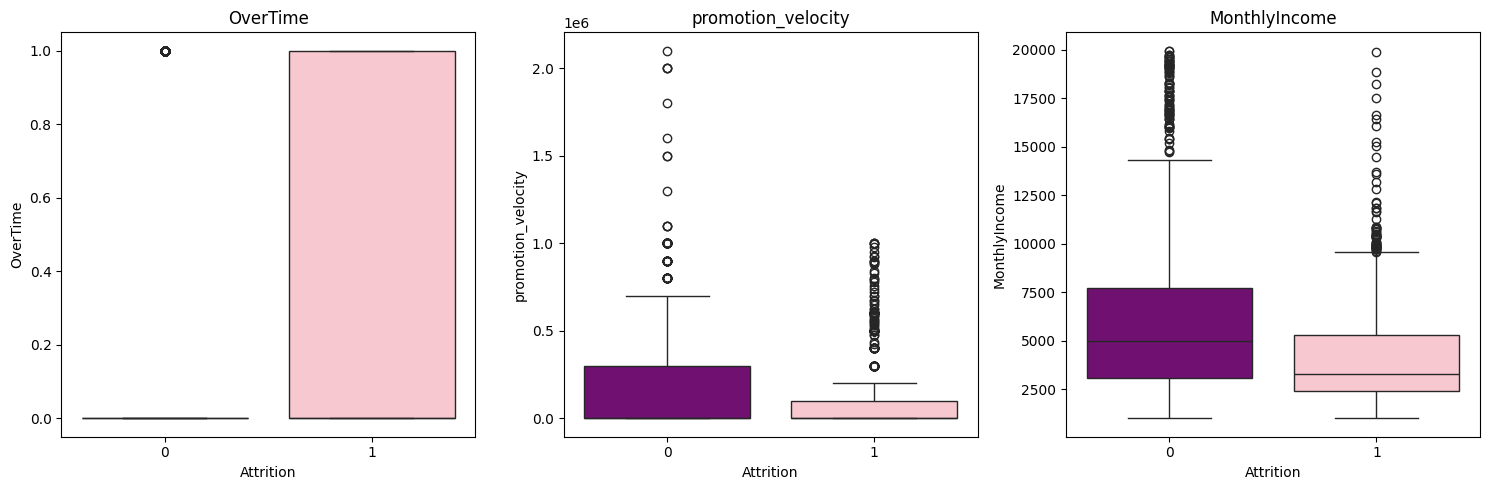

In [11]:
#the top 3 features are selected  based on information gain done in the EDA
top3 = ['OverTime', 'promotion_velocity', 'MonthlyIncome']

plt.figure(figsize=(15, 5))
for i, feature in enumerate(top3, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x='Attrition', y=feature, data=df, palette={'0': 'purple', '1': 'pink'})
    plt.title(f'{feature}')
    plt.xlabel('Attrition')
    plt.ylabel(feature)
plt.tight_layout()
# plt.savefig('results/svm_3boxplot.png')
plt.show()

###**Apply Recursive Feature Elimination (RFE) to select top 14 features as the paper did**


In [12]:
from sklearn.svm import LinearSVC

base_svm = LinearSVC(random_state=42, max_iter=5000)

rfe = RFE(estimator=base_svm, n_features_to_select=14)
rfe.fit(X_train, y_train)

X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

selected_features = X_train.columns[rfe.support_]
print("Number of Selected Features by RFE:", len(selected_features))
print("features:", selected_features)

Number of Selected Features by RFE: 14
features: Index(['BusinessTravel', 'Education', 'EnvironmentSatisfaction', 'Gender',
       'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MaritalStatus',
       'OverTime', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TrainingTimesLastYear', 'workload_score'],
      dtype='object')


In [13]:
X_train_rfe_df = pd.DataFrame(X_train_rfe, columns=selected_features)
X_test_rfe_df = pd.DataFrame(X_test_rfe, columns=selected_features)


# **Model Initialization**

***Following the methodology done in the Paper, I started by initializing a non-linear SVM with RBF kernel to capture complex relationships***

In [14]:
#    without Feature Selection
svm = SVC(kernel='rbf', C=1, gamma='scale', probability=True, random_state=42)

In [15]:
# After applying feature relection usimg RFE:
svm_rfe = SVC(kernel='rbf', C=1, gamma='scale', probability=True, random_state=42)

In [16]:
# I applied cross validation using Grid search to tune the penalty term C, gamma and the suitable kernel to balance both the overfitting and underfitting.
# params = {
#     'C': [0.1, 1],
#     'gamma': ['scale'],
#     'kernel': ['rbf', 'linear']
# }

# grid = GridSearchCV(SVC(probability=True), params, cv=3, scoring='accuracy')
# grid.fit(X_train, y_train)
# best_svm = grid.best_estimator_

# print("Best parameters:", grid.best_params_)
# print("Best cross validation score:", grid.best_score_)

# best_svm.fit(X_train, y_train)

# **Model Training**

In [17]:
#    without feature selection
svm.fit(X_train, y_train)
svm.score(X_train, y_train), svm.score(X_test, y_test)

(0.5494021397105098, 0.36899563318777295)

In [18]:
# After Feature Selection usimg RFE:
svm_rfe.fit(X_train_rfe, y_train)
svm_rfe.score(X_train_rfe, y_train), svm_rfe.score(X_test_rfe, y_test)

(0.8942731277533039, 0.7882096069868996)

# **Model Evaluation**

In [66]:
y_pred = svm_rfe.predict(X_test_rfe)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.89      0.87       373
           1       0.41      0.34      0.37        85

    accuracy                           0.79       458
   macro avg       0.63      0.62      0.62       458
weighted avg       0.77      0.79      0.78       458



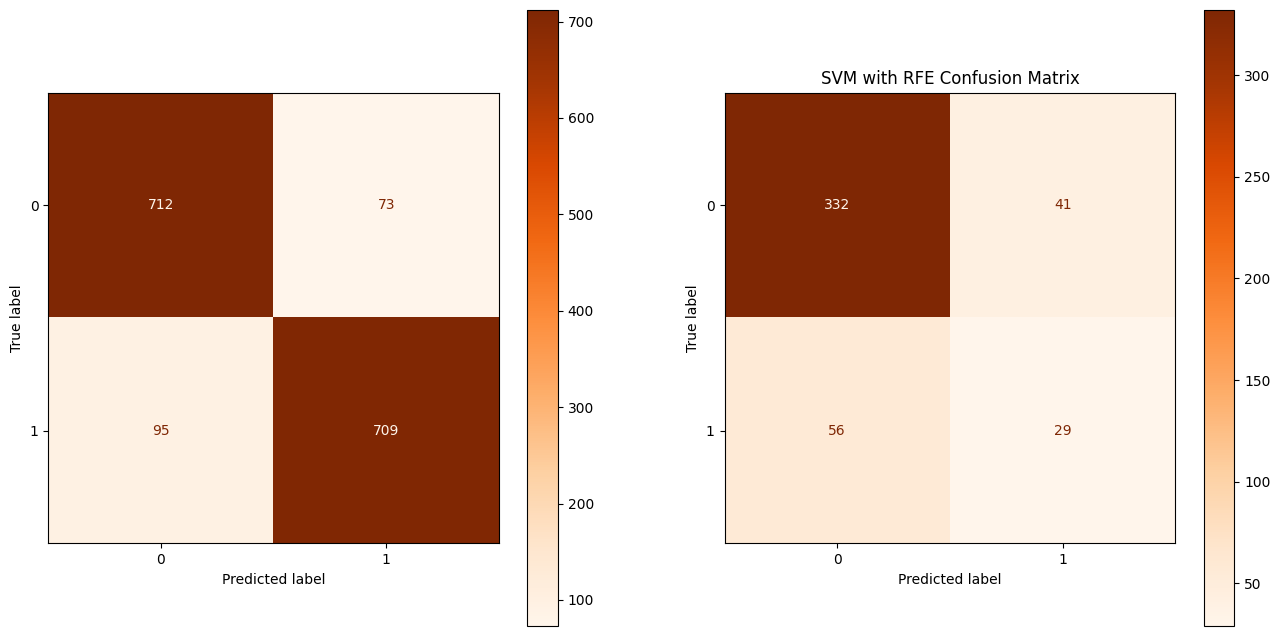

In [20]:
our_confusion_matrix(svm_rfe, X_train_rfe, y_train, X_test_rfe, y_test, name='SVM with RFE')

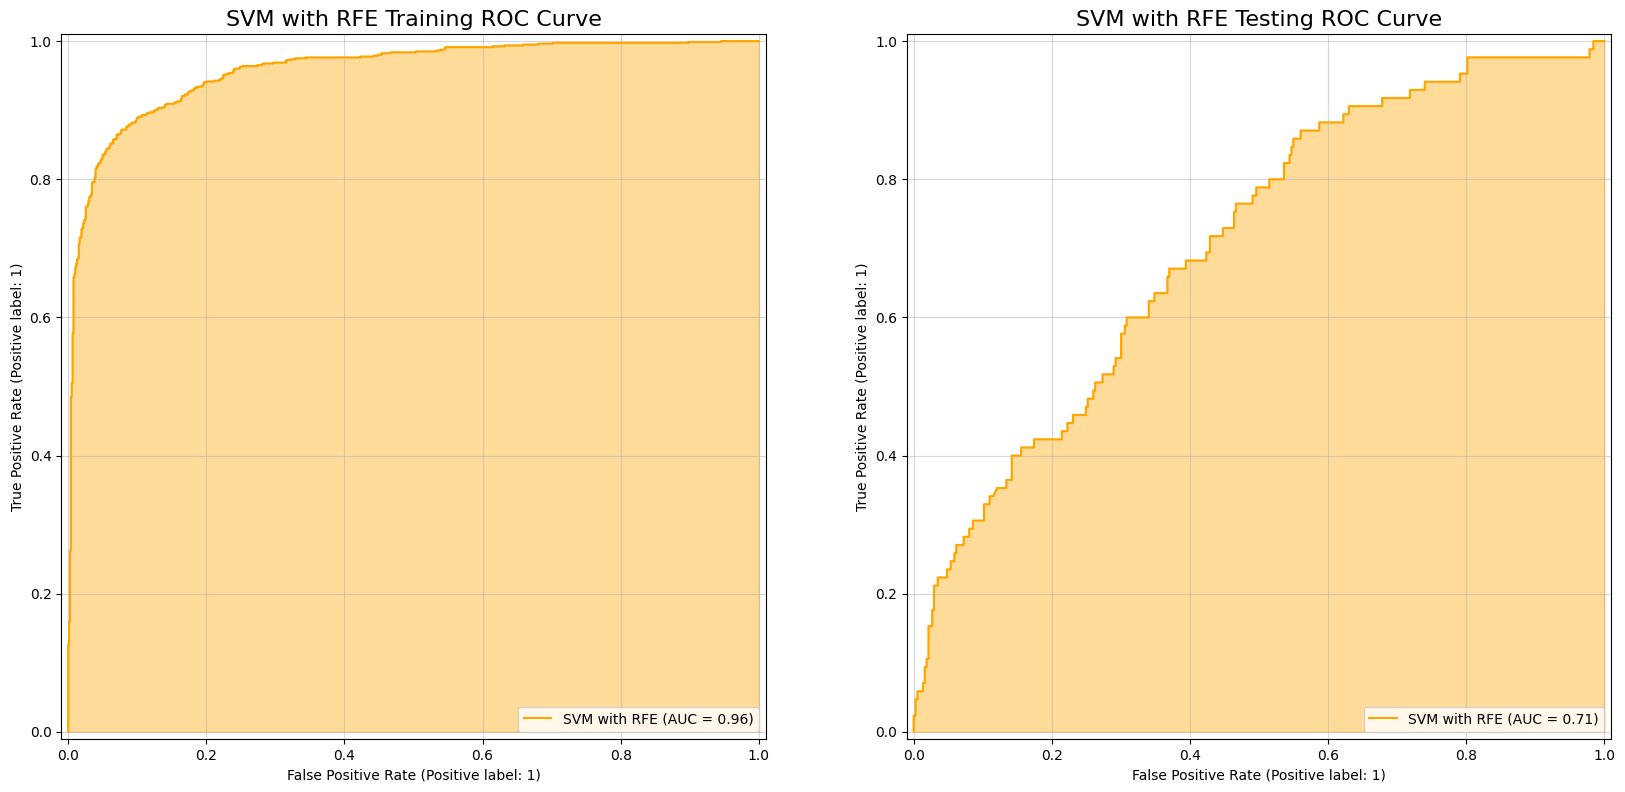

In [21]:
our_roc(svm_rfe, X_train_rfe, y_train, X_test_rfe, y_test, name='SVM with RFE')


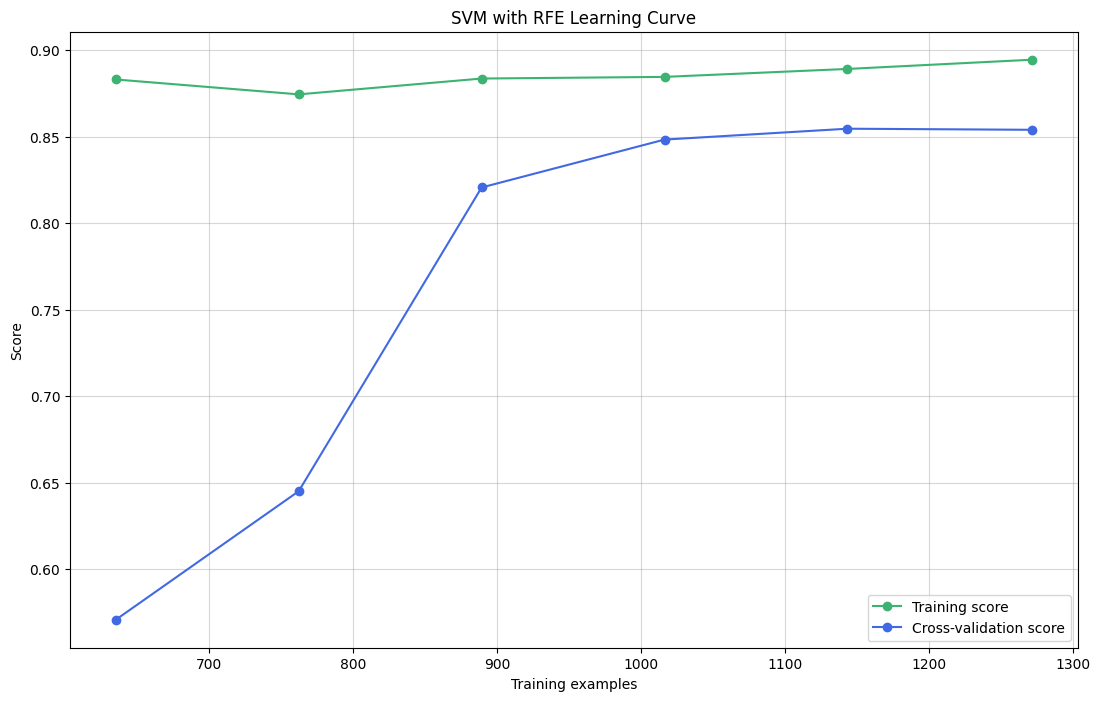

In [22]:
our_learning_curve(svm_rfe, X_train_rfe, y_train, name='SVM with RFE')


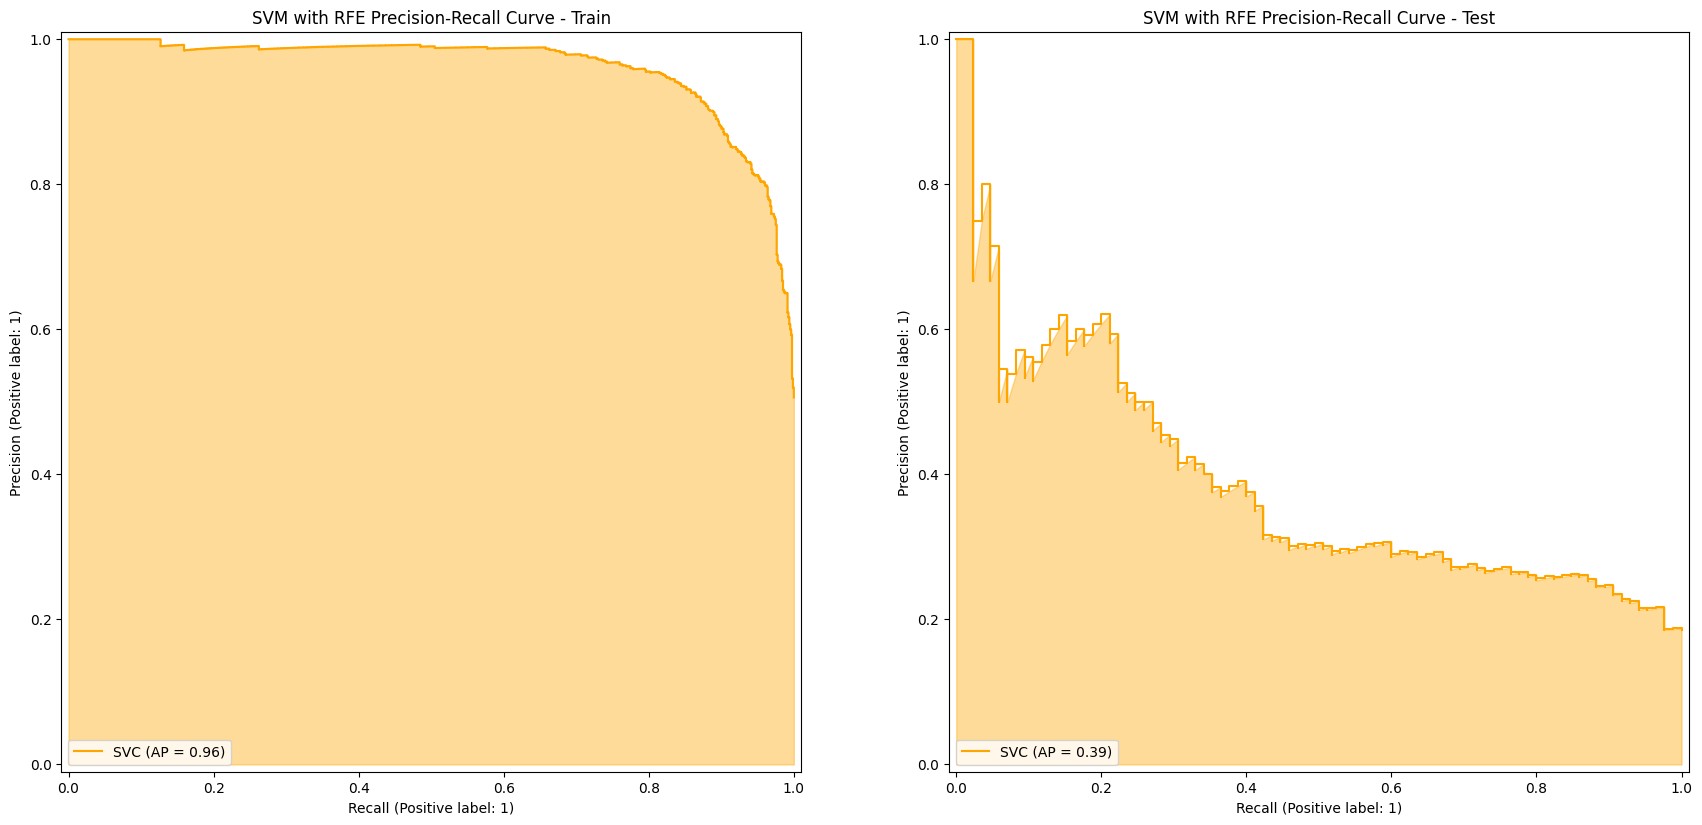

In [23]:
our_prc(svm_rfe, X_train_rfe, y_train, X_test_rfe, y_test, name='SVM with RFE')

> As reported in [SVM Paper], SVM outperformed other models accuracy ≈ 89.7%

> The results confirm that SVM generalizes well to employee attrition prediction.

# **Explainability Techniques**

## LIME Analysis

In [24]:
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(X_train_rfe_df.values, feature_names=X_train_rfe_df.columns, mode='classification',  class_names=['No Attrition', 'Attrition'],
)
exp = explainer.explain_instance(X_test_rfe_df.iloc[0], svm_rfe.predict_proba, num_features=5)
exp.show_in_notebook(show_table=True)

## Interpretation of LIME (After applying RFE)

The LIME plot explains why the SVM model predicts an 88% chance of attrition for this employee

- **High Workload Stress**: `workload_score` (1.00) is the biggest reason for predicting attrition. This insicated thet working overtime leads to high stress wich makes the employee wants to leave.
- **Low Job Level**: `JobLevel` (1.00) indicates an entry level position, indicating limited growth opportunities, which leads to more attrition
- **No Stock Options**: `StockOptionLevel` (0.00) means the employee lacks financial rewards, makes them want to leave more
- **Work Environment**: Low `EnvironmentSatisfaction` (1.00) and medium `RelationshipSatisfaction` (2.00) show an unhappy workplace or not encouraging moood, which leads to the same result, leaving the place.

This aligns with our EDA findings (e.g., overtime and low job satisfaction linked to higher turnover)

## Partial Dependence Plots

Text(0.5, 0.98, 'Partial Dependence for Top Features')

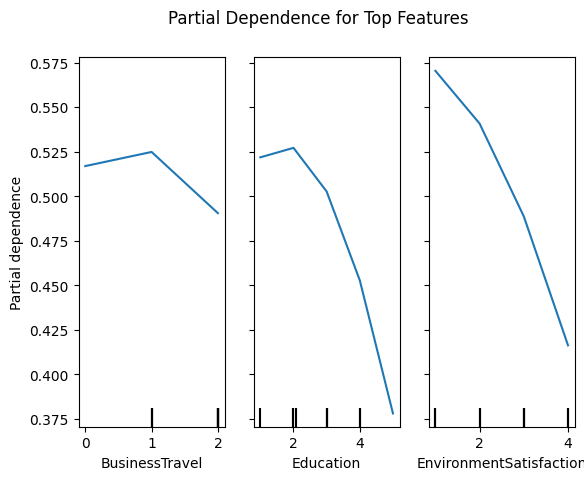

In [46]:
# Code: PDPs for critical features
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(svm_rfe, X_train_rfe_df, features=[0, 1, 2], feature_names=selected_features, kind='average')
plt.suptitle("Partial Dependence for Top Features")


#### PDP

This PDP shows how three features—`BusinessTravel`, `Education`, and `EnvironmentSatisfaction`
- **BusinessTravel**: When `BusinessTravel` goes from 0 to 1, But at 2, it jumps up to 0.55 again. More travel might make leaving more likely.
- **Education**:  More educated employees are less likely to leave.
- **EnvironmentSatisfaction**: Higher satisfaction (from 1 to 4) lowers the chance of leaving a lot (from 0.55 to 0.35). A better work environment helps employees stay.


#**ICE**

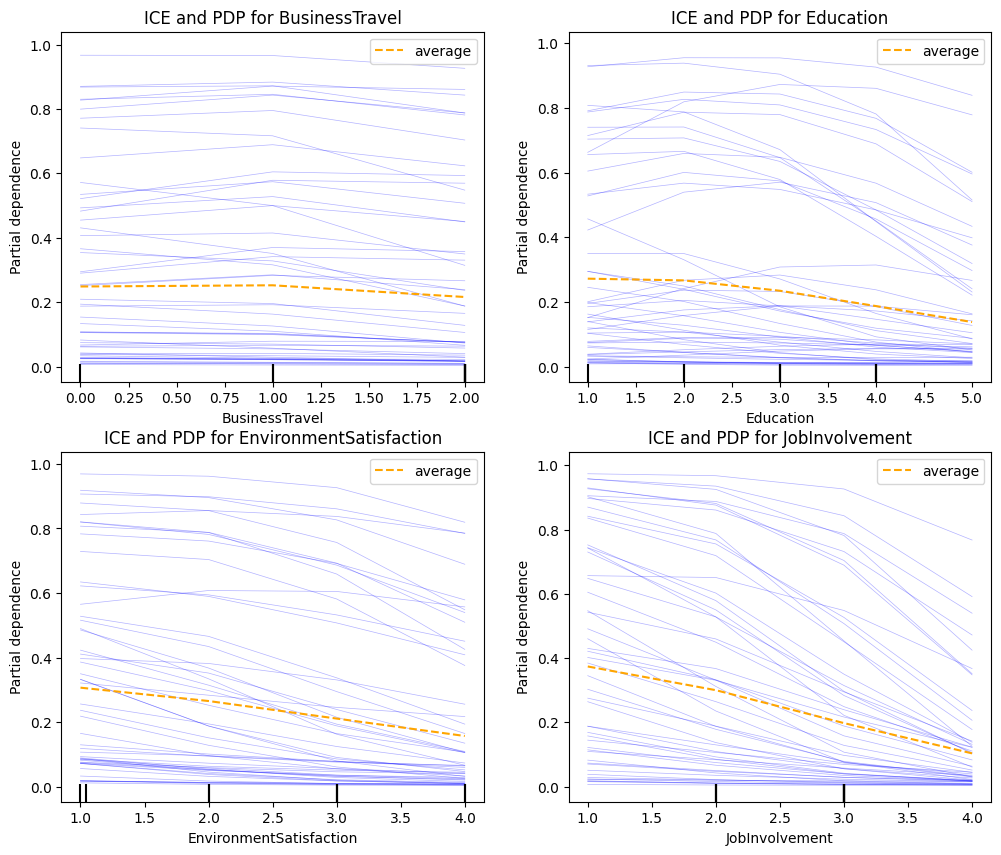

In [45]:
from sklearn.inspection import PartialDependenceDisplay

cols = [c for c in X_test_rfe_df.columns if X_test_rfe_df[c].nunique() > 2][:4]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# ICE and PDP plots for each
for ax, feat in zip(axes.flatten(), cols):
    PartialDependenceDisplay.from_estimator(
        svm_rfe,
        X_test_rfe_df,
        features=[feat],
        feature_names=X_test_rfe_df.columns,
        ax=ax,
        kind='both',
        subsample=50,
        random_state=42,
        ice_lines_kw={'color': 'blue'},
        pd_line_kw={'color': 'orange', 'linestyle': '--'}
    )
    ax.set_title(f'ICE and PDP for {feat}')
    ax.grid(alpha=0.3)

###ICE and PDP Plots for Top Features
These ICE and PDP plots highlight how the SVM model interprets the impact of four features, showing that higher education, satisfaction, and involvement generally reduce the likelihood of leaving

## SHAP Analysis

In [25]:
import shap
explainer = shap.KernelExplainer(svm_rfe.predict_proba, X_test_rfe[:50])
shap_values = explainer.shap_values(X_test_rfe[:50])

  0%|          | 0/50 [00:00<?, ?it/s]

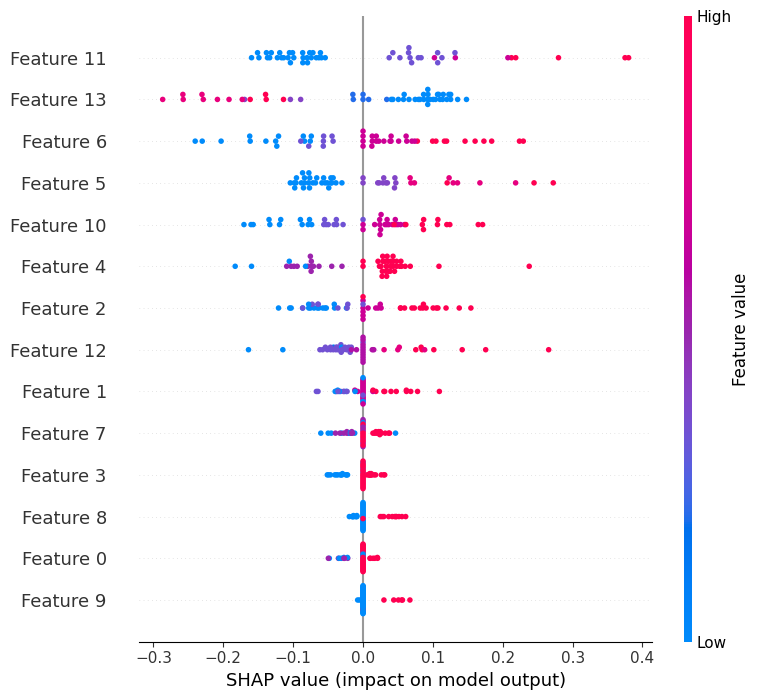

In [57]:
shap.summary_plot(shap_values[:, :, 0], X_test_rfe[:50])  # for Attrition=0

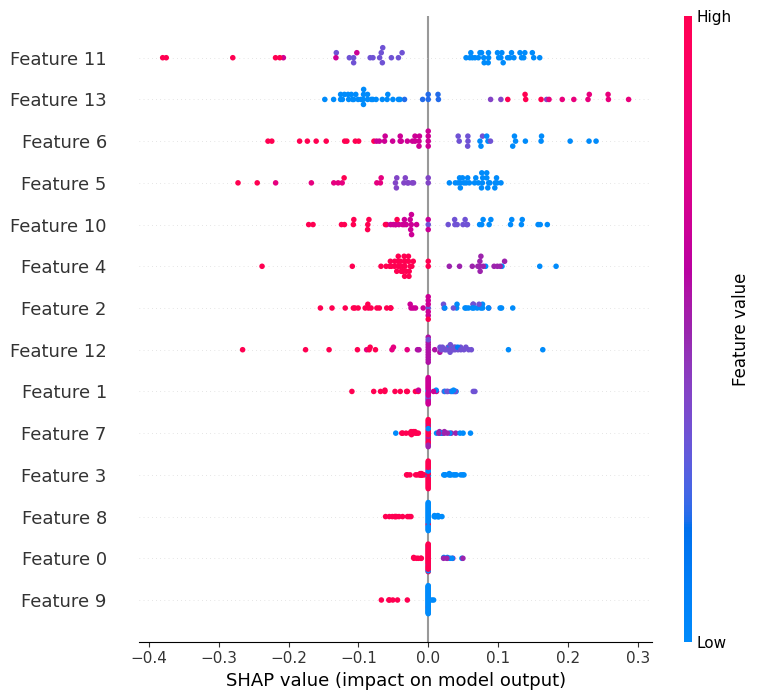

In [59]:
shap.summary_plot(shap_values[:, :, 1], X_test_rfe[:50]) # for Attrition=1

### Summary of SHAP Beeswarm Plots
The SHAP beeswarm plot shows why the SVM model thinks employees will stay, based on 50 employees. Red dots mean high values, blue dots mean low values.

#### Employees Staying (Attrition=0)
- **Main Reasons They Stay**:
  - Low work stress (`workload_score`)
  - Good work environment `EnvironmentSatisfaction`: A nice environment makes them want to stay.
  - Not too much involvement `JobInvolvement`

#### 2nd graph : Employees Leaving (Attrition=1)

- **Main Reasons They Leave**:
  - Too much work stress (`workload_score`): High stress makes leaving more likely.
  - Too much work involvement (`JobInvolvement`): Being too involved makes them tired and want to leave.
  - Bad work environment (`EnvironmentSatisfaction`): A bad environment pushes them to leave.


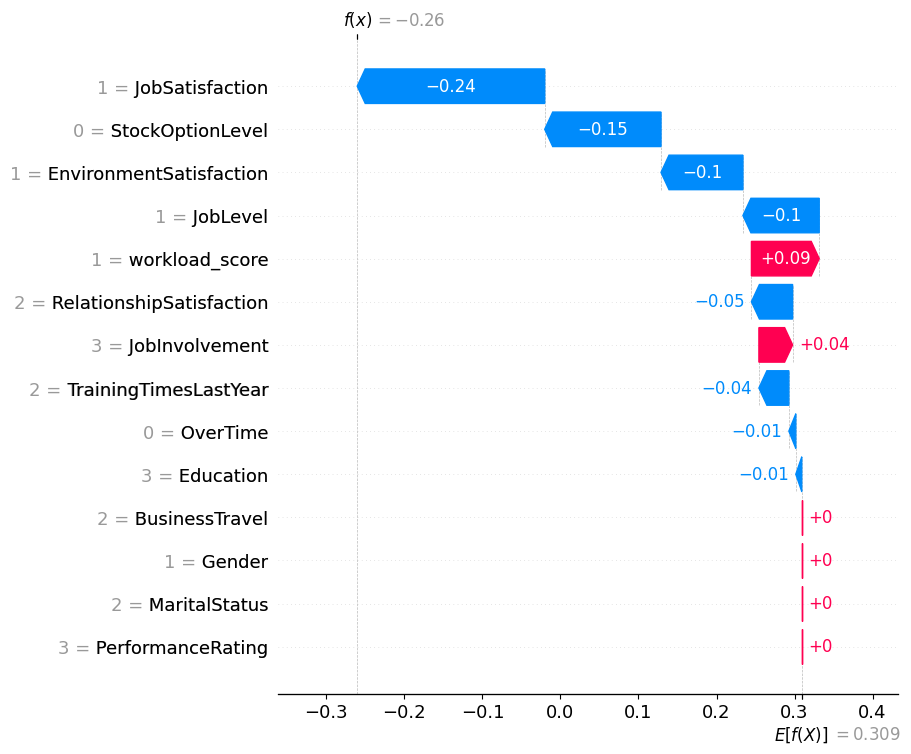

In [61]:
shap_values_exp = shap.Explanation(
    values=shap_values[0][:, 0],
    base_values=explainer.expected_value[1],
    data=X_test_rfe_df.iloc[0],
    feature_names=X_test_rfe_df.columns
)

shap.waterfall_plot(shap_values_exp, max_display=len(X_test_rfe_df.columns))

###**SHAP Waterfall for Atttrition = 1**

This plot shows why the SVM model determined an employee might leave (Attrition=1)
The model gives a score of 0.309 for leaving

- **Red: What makes them want to leave **:
  - `workload_score = 1`: Adds +0.09 to the score. we could interpret from this that the more load the more stress, which leads to leave too.
  - `JobInvolvement = 3`: Adds +0.04, being too involved at job can make them tired and want to leave as well

- **Blue: What makes them want to stay **:
  - `JobSatisfaction = 1`: Lowers the score by -0.24. Low job happiness makes them less likely to leave, maybe because they feel stuck.
  - `EnvironmentSatisfaction = 1` and `JobLevel = 1`: Each lowers the score by -0.1. A bad work environment and a low job level make them less likely to leave, maybe because they don’t have another options and they are have to stickk with their jobs to be financially stable.

**Summary**: This employee might leave because of too much work stress and being too involved in their job. But low happiness, no stock options, and a low job level make them less likely to leave. The final score (0.309) indicates a medium probability of leaving, and that what LIME told us too about workload and job leve